In [1]:
import os
import numpy as np 
import pandas as pd
from scipy import stats, signal, io
import mne
from mne import create_info, EpochsArray
from mne.time_frequency import tfr_morlet
from bids import BIDSLayout
import mne_bids
import scipy
#import settings
import json
#from coordinates_io import BIDS_coord
from sklearn import linear_model, metrics
import multiprocessing
from sklearn.model_selection import cross_val_score
from sklearn import ensemble, model_selection
from matplotlib import pyplot as plt
import matplotlib 

In [2]:
BIDS_path = 'C:\\Users\\ICN_admin\\Documents\\BIDS\\'
subject_id = ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']
out_path = 'C:\\Users\\ICN_admin\\Documents\\Ubuntu_SAVE\\Documents\\raw_out\\LM_100ms\\'

In [3]:
def get_movement_idx(ch, mov_channels, Con=True):
    """returns index of mov_channels given boolean Con and ch
    
    Arguments:
        ch {string} -- given channel string
        mov_channels {list} -- string list of used movement channels including LEFT or RIGHT
    
    Keyword Arguments:
        Con {bool} -- laterality (default: {True})
    
    Returns:
        int -- index of mov_channel of the lateral channel
    """
    mov_idx = 0
    if len(mov_channels) > 1:    
        if Con is True:
            if ("RIGHT" in ch and "LEFT" in mov_channels[0]) or \
                ("LEFT" in ch and "RIGHT" in mov_channels[0]):
                mov_idx = 0
            if ("RIGHT" in ch and "LEFT" in mov_channels[1]) or \
                ("LEFT" in ch and "RIGHT" in mov_channels[1]):
                mov_idx = 1
        else:
            if ("RIGHT" in ch and "RIGHT" in mov_channels[0]) or \
                ("LEFT" in ch and "LEFT" in mov_channels[0]):
                mov_idx = 0
            if ("RIGHT" in ch and "RIGHT" in mov_channels[1]) or \
                ("LEFT" in ch and "LEFT" in mov_channels[1]):
                mov_idx = 1
    return mov_idx


In [4]:
# fs is 10 Hz; estimate the mean +-1 s around the movements
def calc_epochs_f_bands(dat_filtered, y_tr, threshold, epoch_lim):
     
    ind_mov = np.where(np.diff(np.array(y_tr>threshold)*1) == 1)[0]
    low_limit = ind_mov>epoch_lim
    up_limit = ind_mov < y_tr.shape[0]-epoch_lim
    ind_mov = ind_mov[low_limit & up_limit]
    filtered_epoch = np.zeros([ind_mov.shape[0], int(epoch_lim*2), dat_filtered.shape[0]])
    y_arr = np.zeros([ind_mov.shape[0],int(epoch_lim*2)])
    #print(ind_mov)
    for idx, i in enumerate(ind_mov):
        filtered_epoch[idx,:,:] = dat_filtered[:,i-epoch_lim:i+epoch_lim].T
        y_arr[idx,:] = y_tr[i-epoch_lim:i+epoch_lim]

    return filtered_epoch, y_arr

In [5]:
def get_dat(Con = True, ECOG_=True):
    dat_filtered = []
    for subject_id_ in subject_id:
        with open(out_path+'sub_'+subject_id_+'_patient_concat.json', 'r') as fp:
            dict_ch = json.load(fp)

        for ch in list(dict_ch.keys()):
            if (ECOG_ is True and 'ECOG' in ch) or (ECOG_ is False and 'STN' in ch):
                dat_ = np.array(dict_ch[ch]['data'])
                mov_dat = np.array(dict_ch[ch]['true_movements'][get_movement_idx(ch, dict_ch[ch]['mov_ch'], Con=Con)])
                X_epoch, y_epoch = calc_epochs_f_bands(dat_, mov_dat, threshold=0, epoch_lim=20)
                dat_filtered.append(np.mean(X_epoch, axis=0))
    return np.array(dat_filtered)


In [6]:
ECOG_CON_mean_tf = get_dat(True, True)
ECOG_IPS_mean_tf = get_dat(False, True)
STN_CON_mean_tf = get_dat(True, False)
STN_IPS_mean_tf = get_dat(False, False)

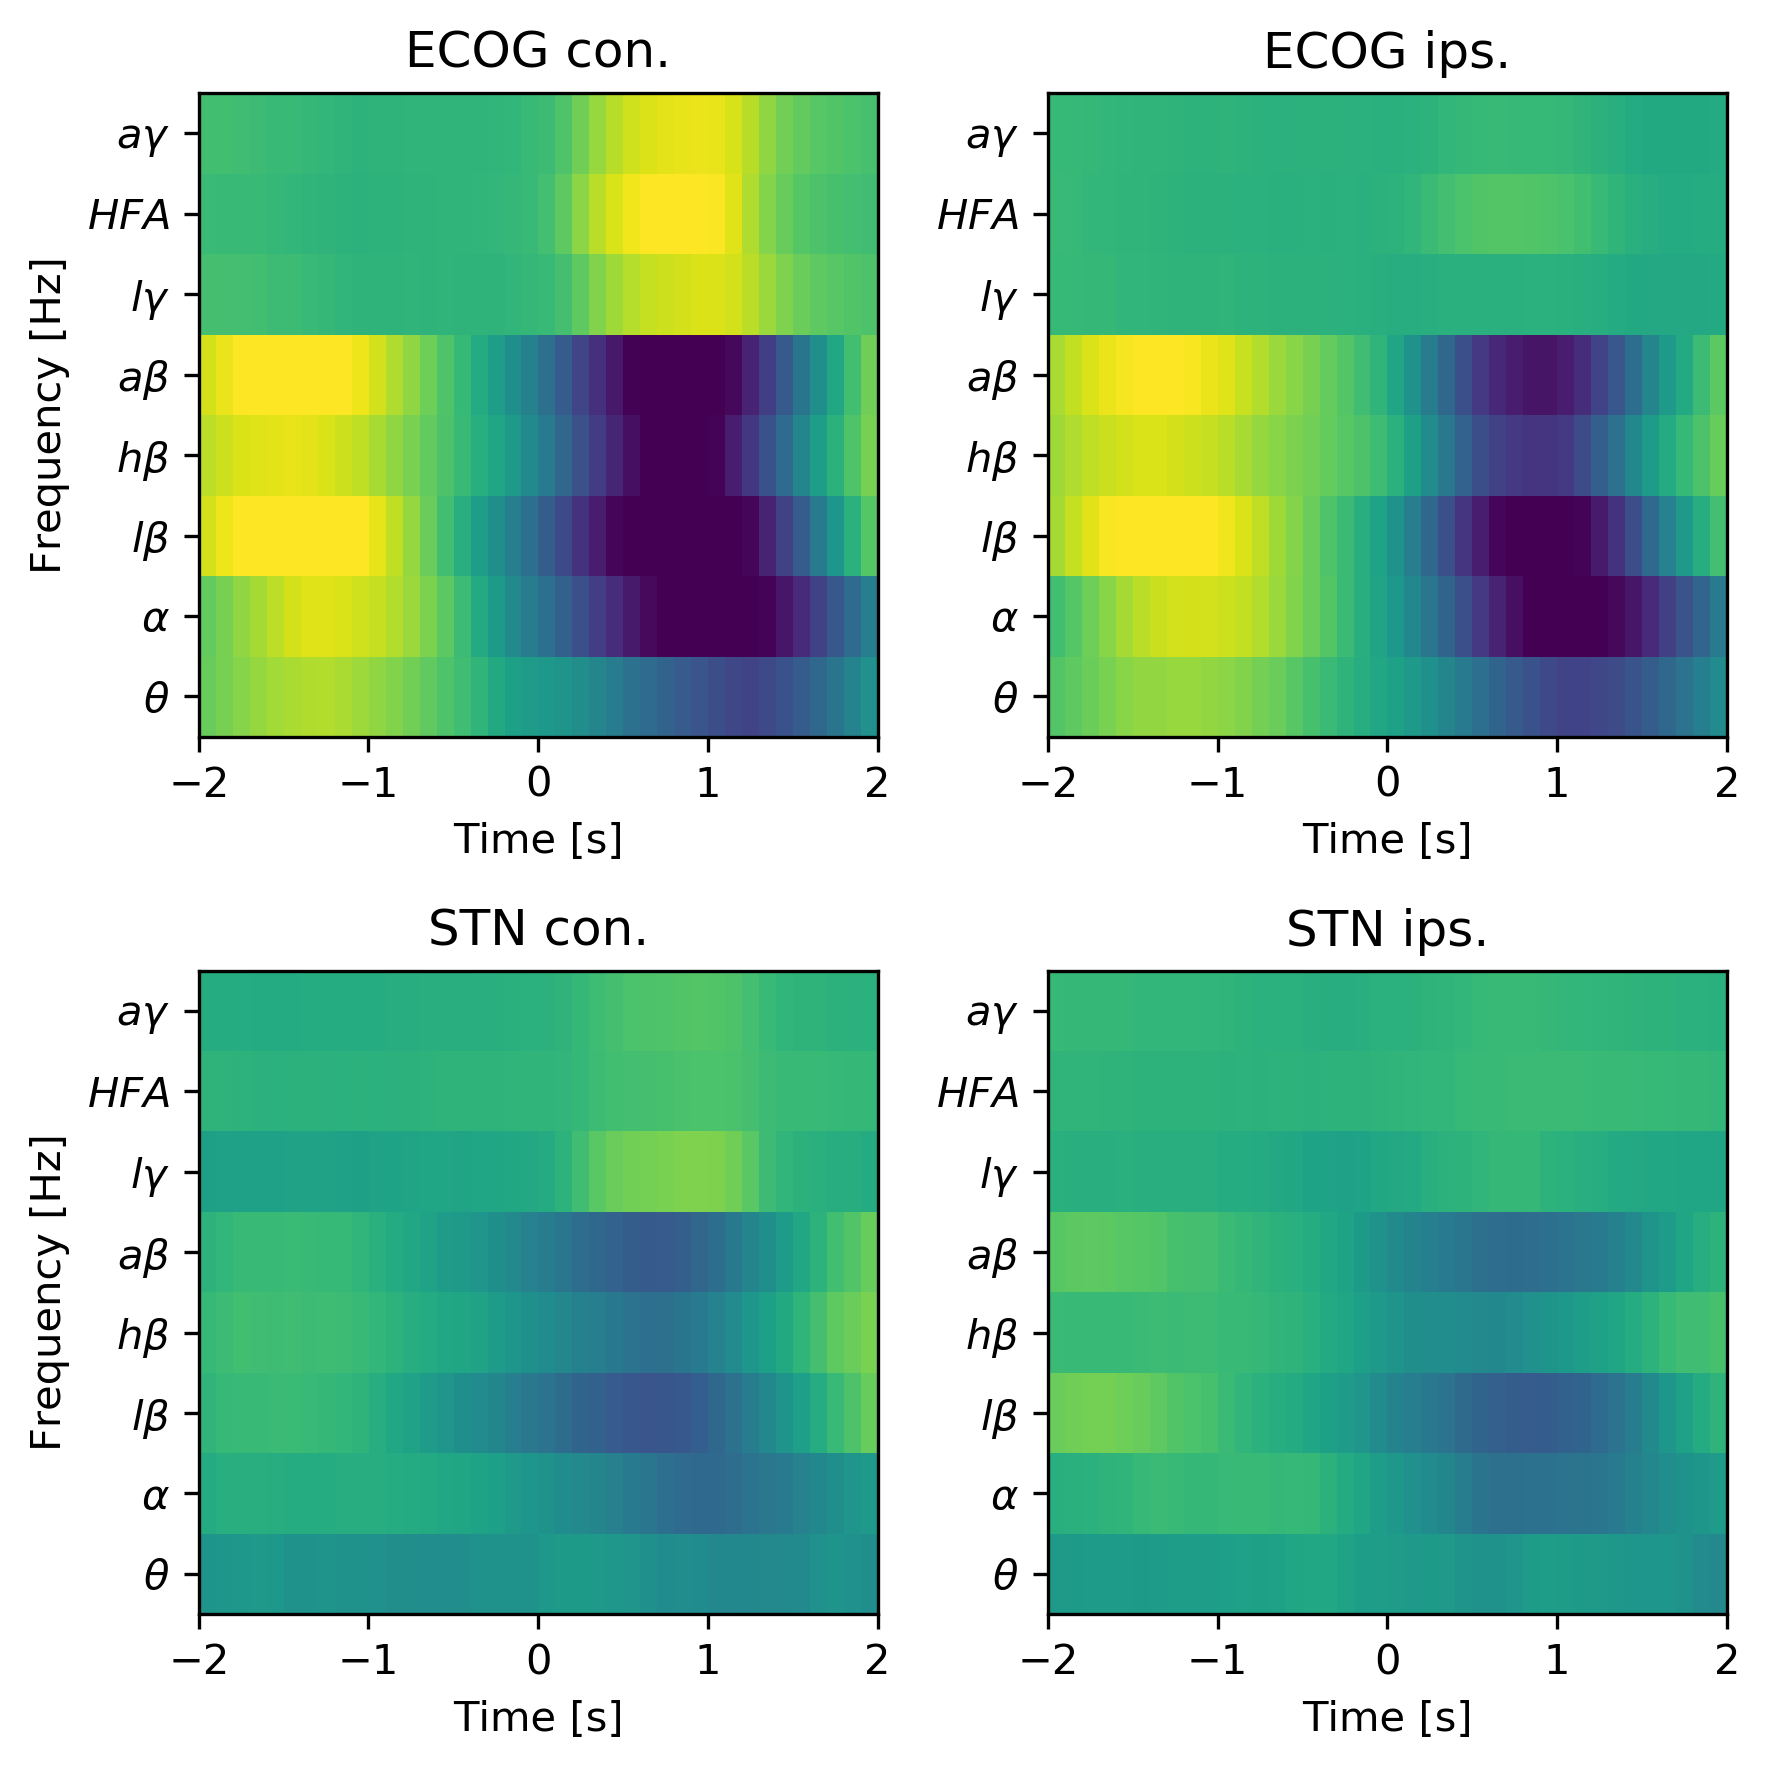

In [7]:
title = ['ECOG con.', 'ECOG ips.', \
        'STN con.', 'STN ips.']
plt.figure(figsize=(6,6), dpi=300)
for idx, dat_ in enumerate([np.mean(ECOG_CON_mean_tf, axis=0), \
        np.mean(ECOG_IPS_mean_tf, axis=0), np.mean(STN_CON_mean_tf,\
        axis=0), np.mean(STN_IPS_mean_tf, axis=0)]):
    plt.subplot(2,2,idx+1)
    im = plt.imshow(dat_.T, aspect='auto', extent=[-2,2,8,0])#, cmap='hot')
    
    #plt.yticks(np.arange(0,8,1), [r'$\theta$', r'$\alpha$', r'$l\beta$', r'$h\beta$', \
    #                         r'$a\beta$', r'$l\gamma$', r'$h\gamma$', r'$a\gamma$'])
    plt.gca().invert_yaxis()
    ax = plt.gca();
    #ax.set_xticks(np.arange(0, 10, 1));
    ax.set_yticks(np.arange(0.5, 8.5, 1));
    ax.set_yticklabels([r'$\theta$', r'$\alpha$', r'$l\beta$', r'$h\beta$', \
                             r'$a\beta$', r'$l\gamma$', r'$HFA$', r'$a\gamma$']);

    plt.clim(0.5,1.2)
    #cbar = plt.colorbar()
    #cbar.set_label('Normalized spectral power [VAR]')
    plt.title(title[idx])
    if idx == 0 or idx == 2:
        plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
plt.tight_layout()